<a href="https://colab.research.google.com/github/etodasha/PRA-M2.875-2020.2/blob/main/PRA_DL_Inception_%2B_final_metrics_%2B_test_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [3]:
!kaggle datasets download "jordidelatorreuoc/kaggle-plant-pathology-2021-modificat"

100% 967M/970M [00:11<00:00, 104MB/s] 
100% 970M/970M [00:11<00:00, 88.1MB/s]


In [ ]:
!unzip kaggle-plant-pathology-2021-modificat.zip

In [5]:
import pandas as pd
import numpy as np 
import tensorflow as tf
import keras 
import os
import matplotlib.pylab as plt
import cv2
from keras.preprocessing.image import ImageDataGenerator 
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, ZeroPadding2D, GlobalAveragePooling2D,BatchNormalization, AveragePooling2D, Input, concatenate
from keras.optimizers import Adam, SGD,RMSprop,Adadelta,Adagrad,Adamax,Nadam,Ftrl
from keras.layers.experimental.preprocessing import Resizing
from keras.callbacks import *
from sklearn import metrics


In [ ]:
datagen_train = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8,1.2],
    zoom_range=[0.5,1.2],
    rotation_range=20,
    rescale=1./255,
    validation_split=0.2) 

train_generator = datagen_train.flow_from_directory( 
    'train',
    subset='training')

validation_generator = datagen_train.flow_from_directory(
    'train',
    subset='validation'
    ,shuffle=False)



Found 7800 images belonging to 6 classes.
Found 1950 images belonging to 6 classes.


In [9]:
from keras import backend as K

def custom_recall(y_true, y_pred):
  TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = TP / (Positives+K.epsilon())
  return recall 

def custom_precision(y_true, y_pred):
  TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = TP / (Pred_Positives+K.epsilon())
  return precision

def custom_f1(y_true, y_pred):    
    precision, recall = custom_precision(y_true, y_pred), custom_recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


self-built inception 

In [10]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [11]:

input_layer = Input(shape=(332, 498, 3))
resizing = Resizing(224,224)(input_layer)

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2')(resizing)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(6, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(6, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(6, activation='softmax', name='output')(x)


my_inception = Model(input_layer, [x, x1, x2], name='inception_v1')
my_inception.summary()

Model: "inception_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 332, 498, 3) 0                                            
__________________________________________________________________________________________________
tf.image.resize (TFOpLambda)    (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv_1_7x7/2 (Conv2D)           (None, 112, 112, 64) 9472        tf.image.resize[0][0]            
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 56, 56, 64)   0           conv_1_7x7/2[0][0]               
_______________________________________________________________________________________

In [ ]:
my_inception.compile(optimizer = Adam(learning_rate=0.0001),
              loss = "categorical_crossentropy", 
              metrics = ['accuracy',custom_f1,custom_recall,custom_precision])


early_stopping = keras.callbacks.EarlyStopping(monitor='val_output_custom_f1', mode='max', patience=25, 
                                               restore_best_weights=True, verbose=2)

filepath = "/content/gdrive/My Drive/Inception_epochs:{epoch:03d}-val_f1:{val_output_custom_f1:.3f}.hdf5"

checkpoint_callback = ModelCheckpoint(filepath= filepath, monitor='val_output_custom_f1', mode='max',
                                                         save_weights_only=True, save_best_only=True)

# first 100 epochs
inception_history = my_inception.fit(train_generator,
                              validation_data = validation_generator,
                              epochs=100,
                              batch_size=128,
                              callbacks=[early_stopping, checkpoint_callback]) 

Epoch 1/100
244/244 [==============================] - 172s 676ms/step - loss: 4.3699 - output_loss: 1.4637 - auxilliary_output_1_loss: 1.4509 - auxilliary_output_2_loss: 1.4552 - output_accuracy: 0.4539 - output_custom_f1: 0.3107 - output_custom_recall: 0.2210 - output_custom_precision: 0.6168 - auxilliary_output_1_accuracy: 0.4690 - auxilliary_output_1_custom_f1: 0.3254 - auxilliary_output_1_custom_recall: 0.2287 - auxilliary_output_1_custom_precision: 0.6240 - auxilliary_output_2_accuracy: 0.4603 - auxilliary_output_2_custom_f1: 0.3188 - auxilliary_output_2_custom_recall: 0.2244 - auxilliary_output_2_custom_precision: 0.6367 - val_loss: 4.4167 - val_output_loss: 1.4865 - val_auxilliary_output_1_loss: 1.4549 - val_auxilliary_output_2_loss: 1.4752 - val_output_accuracy: 0.4415 - val_output_custom_f1: 0.3776 - val_output_custom_recall: 0.3509 - val_output_custom_precision: 0.4098 - val_auxilliary_output_1_accuracy: 0.4508 - val_auxilliary_output_1_custom_f1: 0.3709 - val_auxilliary_out

In [ ]:

my_inception.compile(optimizer = Adam(learning_rate=0.0001),
              loss = "categorical_crossentropy", 
              metrics = ['accuracy',custom_f1,custom_recall,custom_precision])

my_inception.load_weights('/content/gdrive/My Drive/Inception_epochs:098-val_f1:0.899.hdf5')

early_stopping = keras.callbacks.EarlyStopping(monitor='val_output_custom_f1', mode='max', patience=25, 
                                               restore_best_weights=True, verbose=2)

filepath = "/content/gdrive/My Drive/Inception_epochs:{epoch:03d}-val_f1:{val_output_custom_f1:.3f}.hdf5"

checkpoint_callback = ModelCheckpoint(filepath= filepath, monitor='val_output_custom_f1', mode='max',
                                                         save_weights_only=True, save_best_only=True)

# secong 100 epochs
inception_history = my_inception.fit(train_generator,
                              validation_data = validation_generator,
                              initial_epoch=100,
                              epochs=200,
                              batch_size=128,
                              callbacks=[early_stopping, checkpoint_callback]) 

Epoch 101/200
244/244 [==============================] - 224s 702ms/step - loss: 0.7252 - output_loss: 0.2324 - auxilliary_output_1_loss: 0.2605 - auxilliary_output_2_loss: 0.2323 - output_accuracy: 0.9167 - output_custom_f1: 0.9178 - output_custom_recall: 0.9104 - output_custom_precision: 0.9256 - auxilliary_output_1_accuracy: 0.9106 - auxilliary_output_1_custom_f1: 0.9131 - auxilliary_output_1_custom_recall: 0.9018 - auxilliary_output_1_custom_precision: 0.9250 - auxilliary_output_2_accuracy: 0.9207 - auxilliary_output_2_custom_f1: 0.9215 - auxilliary_output_2_custom_recall: 0.9136 - auxilliary_output_2_custom_precision: 0.9298 - val_loss: 1.1136 - val_output_loss: 0.3807 - val_auxilliary_output_1_loss: 0.3637 - val_auxilliary_output_2_loss: 0.3692 - val_output_accuracy: 0.8795 - val_output_custom_f1: 0.8776 - val_output_custom_recall: 0.8708 - val_output_custom_precision: 0.8847 - val_auxilliary_output_1_accuracy: 0.8723 - val_auxilliary_output_1_custom_f1: 0.8711 - val_auxilliary_o

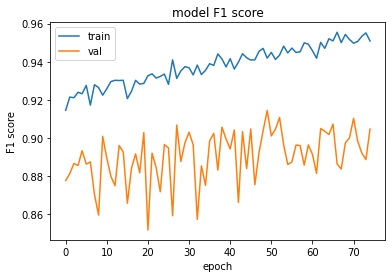

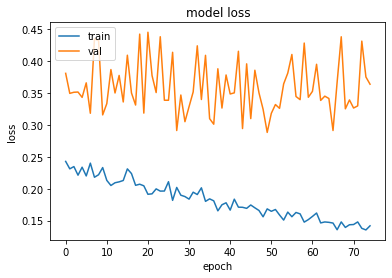

In [ ]:
# History plot
import matplotlib.pyplot as plt
import numpy as np


plt.plot(inception_history.history['output_custom_f1'])
plt.plot(inception_history.history['val_output_custom_f1'])
plt.title('model F1 score')
plt.ylabel('F1 score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


plt.plot(inception_history.history['output_loss'])
plt.plot(inception_history.history['val_output_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Métricas

In [12]:
# best model load
my_inception.compile(optimizer = Adam(learning_rate=0.0001),
              loss = "categorical_crossentropy", 
              metrics = ['accuracy',custom_f1,custom_recall,custom_precision])

my_inception.load_weights('/content/gdrive/My Drive/Inception_epochs:150-val_f1:0.914.hdf5')

In [ ]:
validation_generator.class_indices

{'C0': 0, 'C1': 1, 'C2': 2, 'C3': 3, 'C4': 4, 'C5': 5}

In [ ]:
# Validation prediction 
pred_y_classes =  np.argmax(my_inception.predict(validation_generator), axis=-1)[0] # main output predictions

In [ ]:
pd.DataFrame(metrics.confusion_matrix(validation_generator.labels, pred_y_classes), 
                               index=list(validation_generator.class_indices.keys()), 
                               columns=list(validation_generator.class_indices.keys()))

,C0,C1,C2,C3,C4,C5
C0,766,14,2,15,0,3
C1,3,193,0,2,2,0
C2,3,1,213,2,17,4
C3,8,7,1,198,5,1
C4,3,3,17,13,201,23
C5,4,4,0,5,29,188


In [ ]:
print(metrics.classification_report(validation_generator.labels, pred_y_classes, target_names=list(validation_generator.class_indices.keys()) ))

              precision    recall  f1-score   support

          C0       0.97      0.96      0.97       800
          C1       0.87      0.96      0.91       200
          C2       0.91      0.89      0.90       240
          C3       0.84      0.90      0.87       220
          C4       0.79      0.77      0.78       260
          C5       0.86      0.82      0.84       230

    accuracy                           0.90      1950
   macro avg       0.87      0.88      0.88      1950
weighted avg       0.90      0.90      0.90      1950



Predicciones conjunto test 

In [14]:
datagen_test = ImageDataGenerator(rescale=1./255) 

test_generator = datagen_test.flow_from_directory('test',class_mode=None)

Found 7527 images belonging to 1 classes.


In [15]:
test_pred = np.argmax(my_inception.predict(test_generator), axis=-1)[0]
test_pred = ['C'+str(x) for x in test_pred]

In [16]:
images = []
with os.scandir('test/test') as out:
    images = [dir.name for dir in out if dir.name!='.ipynb_checkpoints'] 

In [22]:
pd.DataFrame([images,test_pred],index=['image','label']).T

,image,label
0,YctjPvpjPx.jpg,C2
1,XEgd9wG8rt.jpg,C0
2,d5NiNuSmxR.jpg,C3
3,aD8Y91cjgd.jpg,C5
4,qPSIjXsssZ.jpg,C0
...,...,...
7522,QpMvb7Bors.jpg,C3
7523,m16a24nJPZ.jpg,C3
7524,wATyrKvTkk.jpg,C4
7525,Td9QFbFIrS.jpg,C5


In [23]:
pd.DataFrame([images,test_pred],index=['image','label']).T.to_csv('test.csv', index=False)

from google.colab import files
files.download('test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>